# Weather prediction example

This notebook shows a advanced way to predict time series data using a PredictLite neural network

(c) Mikko Kursula 2022 - 2024. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data
station_id = '02944'
start_dt = datetime(2017, 1, 1)
end_dt = datetime(2022, 1, 1)
dataset = meteostat.Hourly(station_id, start_dt, end_dt).fetch()
dataset.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2017-01-01 00:00:00,0.1,-3.1,79.0,NaN,NaN,230.0,13.0,NaN,996.5,NaN,NaN
2017-01-01 01:00:00,-0.5,-2.9,84.0,NaN,NaN,230.0,14.8,NaN,996.4,NaN,NaN
2017-01-01 02:00:00,0.0,-2.2,85.0,NaN,NaN,220.0,9.4,NaN,996.6,NaN,NaN
2017-01-01 03:00:00,-2.2,-3.6,90.0,NaN,NaN,230.0,13.0,NaN,996.6,NaN,NaN
2017-01-01 04:00:00,-3.2,-4.2,93.0,NaN,NaN,240.0,11.2,NaN,996.8,NaN,NaN


### Create categorical features
This example creates precipitation category with binary values raining/not raining.

In [3]:
dataset['prcp'] = dataset['prcp'].fillna(0)
dataset['prcp_cat'] = (dataset['prcp'] > 0).astype(str)

### Setup and train PredictLite model 

In [5]:
model = PredictLite(
    input_signals=['temp', 'rhum'], 
    input_preprocessing={'temp' : 'z-norm', 'rhum' : 'z-norm'},
    datetime_embeddings=['month', 'hour'],
    datetime_embedding_dim=4,
    categorical_inputs=['prcp_cat'],
    categorical_embedding_dim=4,
    input_length=72, 
    output_signals=['temp', 'rhum'],
    output_length=24,
    data_sample_period=3600,
    sequential_layer_neurons=[10],
    longitudinal_layer_neurons=[50, 50],
    flattened_layer_neurons=[100, 50],
)


model.fit(
    dataset,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    random_seed=13,
    verbose=True,
)

Setting up preprocessing
Building dataset
Training the model
epoch:   0, train loss: 0.68256, test loss: 0.45270
epoch:   1, train loss: 0.35057, test loss: 0.29966
epoch:   2, train loss: 0.26814, test loss: 0.25136
epoch:   3, train loss: 0.24266, test loss: 0.23287
epoch:   4, train loss: 0.23170, test loss: 0.22416
epoch:   5, train loss: 0.22577, test loss: 0.22069
epoch:   6, train loss: 0.22135, test loss: 0.21689
epoch:   7, train loss: 0.21843, test loss: 0.21700
epoch:   8, train loss: 0.21597, test loss: 0.21467
epoch:   9, train loss: 0.21357, test loss: 0.21125
epoch:  10, train loss: 0.21138, test loss: 0.21141
epoch:  11, train loss: 0.20932, test loss: 0.21214
epoch:  12, train loss: 0.20793, test loss: 0.20853
epoch:  13, train loss: 0.20652, test loss: 0.20555
epoch:  14, train loss: 0.20548, test loss: 0.20590
epoch:  15, train loss: 0.20457, test loss: 0.20668
epoch:  16, train loss: 0.20273, test loss: 0.20907
epoch:  17, train loss: 0.20144, test loss: 0.20532
epo

In [6]:
model.model_summary()

Inputs:
	Float inputs: ['temp', 'rhum']
	Time steps: 72
	month_emb: num_embeddings: 13, embedding_dim: 4
	hour_emb: num_embeddings: 25, embedding_dim: 4
	prcp_cat: num_embeddings: 2, embedding_dim: 4
MLP sequential part:
	Linear(in_features=14, out_features=10, bias=True), parameter count: 150
	Mish()
	Flatten(start_dim=-2, end_dim=-1)
MLP longitudinal part:
	Linear(in_features=72, out_features=50, bias=True), parameter count: 3650
	Mish()
	Linear(in_features=50, out_features=50, bias=True), parameter count: 2550
	Mish()
	Flatten(start_dim=-2, end_dim=-1)
MLP flattened part:
	Linear(in_features=1420, out_features=100, bias=True), parameter count: 142100
	Mish()
	Linear(in_features=100, out_features=50, bias=True), parameter count: 5050
	Mish()
	Linear(in_features=50, out_features=48, bias=True), parameter count: 2448

Total MLP parameter count: 155948


### Make prediction

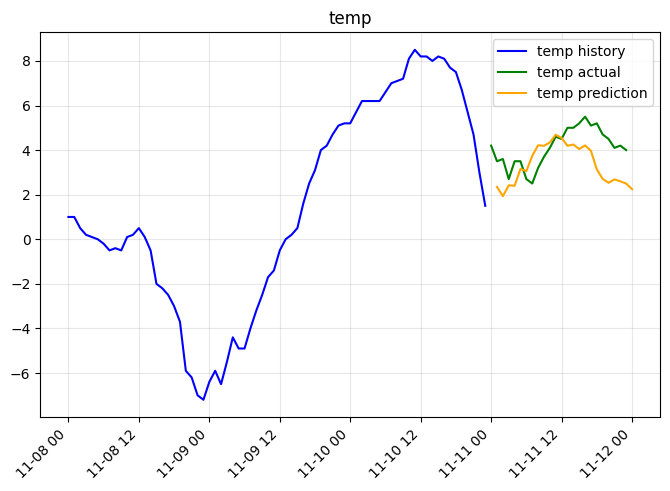

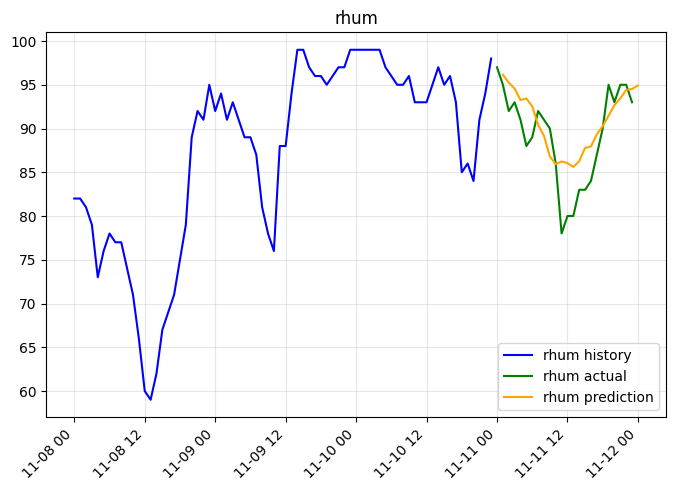

In [7]:
# Datetime for prediction start
prediction_time = datetime(2021, 11, 11, 0)

# Make prediction 
pred = model.predict(dataset, prediction_time)

# Plot data and prediction
pred_len = model.output_length
inp_len = model.input_length
for col in model.output_signals:
    
    ts_idx = dataset.index.get_indexer([prediction_time], method='pad')[0]
    plt.figure(figsize=(8, 5))
    plt.plot(
        dataset.index[ts_idx - inp_len : ts_idx].values, 
        dataset.iloc[ts_idx - inp_len : ts_idx][col].values, 
        color='blue', 
        label='{} history'.format(col)
    )
    plt.plot(
        dataset.index[ts_idx : ts_idx + pred_len].values, 
        dataset.iloc[ts_idx : ts_idx + pred_len][col].values, 
        color='green',
        label='{} actual'.format(col)
    )
    plt.plot(
        pred.index.values, 
        pred[col].values, 
        color='orange', 
        label='{} prediction'.format(col)
    )
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(col)
    plt.show()